In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import ssl
import random
from pathlib import Path
from art.estimators.classification import PyTorchClassifier
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import time

ssl._create_default_https_context = ssl._create_stdlib_context

/Users/giorgos/PycharmProjects/defensive_distillation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
writer = SummaryWriter(f'runs/notebook-{time.strftime('%m%d-%H%M%S')}')

In [3]:
# Ensure reproducibility

# Set a global random seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

here

In [4]:
# Teacher Model
lr = 0.001
batch_size = 128
n_channels, w, h = 1, 28, 28
max_epochs = 5

In [5]:
# Attacks
max_attack_iter = 50

In [6]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Playing on {device}")

Playing on mps


In [7]:
dt_p = Path('data/mnist')

classes = [str(i) for i in range(10)]
n_labels = len(classes)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])


trainset = datasets.MNIST(root=f'{dt_p.absolute()}/train', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testset = datasets.MNIST(root=f'{dt_p.absolute()}/test', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

In [8]:
class MnistNet(nn.Module):
    def __init__(self, input_size=28, temperature=1):  # Add input size for flexibility
        super().__init__()
        self.conv1a = nn.Conv2d(1, 32, 3, padding=0)
        self.conv1b = nn.Conv2d(32, 32, 3, padding=0)
        self.conv2a = nn.Conv2d(32, 64, 3, padding=0)
        self.conv2b = nn.Conv2d(64, 64, 3, padding=0)
        self.pool = nn.MaxPool2d(2, 2)

        # Compute the number of features dynamically
        self._to_linear = self._get_conv_output(input_size)

        self.fc1 = nn.Linear(self._to_linear, 200)
        self.fc2 = nn.Linear(200, 10)

        self.flatten = nn.Flatten()
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.batchnorm = nn.BatchNorm1d(200)  # Now correctly applied

        self.temperature = temperature

    def _get_conv_output(self, size):
        """Helper function to compute the output size after convolutions"""
        x = torch.zeros(1, 1, size, size)  # Create a dummy tensor
        x = self.pool(F.relu(self.conv1b(F.relu(self.conv1a(x)))))
        x = self.pool(F.relu(self.conv2b(F.relu(self.conv2a(x)))))
        return x.numel()

    def forward(self, x):
        x = self.activation(self.conv1a(x))
        x = self.activation(self.conv1b(x))
        #x = self.dropout(x)
        x = self.pool(x)
        x = self.activation(self.conv2a(x))
        x = self.activation(self.conv2b(x))
        #x = self.dropout(x)
        x = self.pool(x)

        x = self.flatten(x)  # Flatten before FC layers
        x = self.activation(self.fc1(x))
        #x = self.batchnorm(x)
        x = self.fc2(x)
        # CrossEntropyLoss already applied softmax
        x = F.log_softmax(x / self.temperature, dim=1)  # Use log_softmax for numerical stability
        return x  # Remove softmax if using CrossEntropyLoss



In [9]:
temp_teacher = 20.0

In [10]:
# Specify teacher model

teacher_model = MnistNet(input_size=28, temperature=temp_teacher).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(teacher_model.parameters(), lr=lr)

In [ ]:
# Train the teacher model
teacher_losses = []

for e in tqdm(range(max_epochs)):
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        logits = teacher_model(images)
        # Compute loss
        loss = criterion(logits, labels)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    teacher_losses.append(loss.item())
    
    if e % 10 == 0 or e == max_epochs-1:
        print(f"Epoch {e}: {loss.item()}")

 20%|██        | 1/5 [00:04<00:17,  4.45s/it]

Epoch 0: 0.12312939018011093


100%|██████████| 5/5 [00:20<00:00,  4.04s/it]

Epoch 4: 0.0012559281894937158


In [12]:
# Wrap in ART PyTorchClassifier
art_model_t = PyTorchClassifier(
    model=teacher_model,
    clip_values=(0, 1),  # Min and Max pixel values (normalize if needed)
    loss=criterion,
    optimizer=optimizer,
    input_shape=(n_channels, w, h),
    nb_classes=10
)

In [13]:
mnist_targets = testset.targets.int().numpy()
mnist_data = testset.data.unsqueeze(1).float().numpy()  # Add channel dimension (N, 1, 28, 28)

In [14]:
# Computationally Expensive methods -> Select Test Subset
num_samples = 100
# First shuffle
indices = torch.randperm(len(testset.data))
mnist_data_shuffled = mnist_data[indices]
mnist_targets_shuffled = mnist_targets[indices]
# Then select subsets
mnist_data_subset = mnist_data_shuffled[:num_samples]/255
mnist_targets_subset = mnist_targets_shuffled[:num_samples]

In [15]:
# Create all target classes

# All digit classes
int_classes = np.arange(10)

target_y = [int_classes[int_classes != label].tolist() for label in mnist_targets_subset]
# Transpose to create label subsets
target_y = np.array(target_y).T


In [16]:
# Test it out - Similarity between target vectors and original labels must be 0

vec_similarity = []
for target_vec in target_y:
    vec_similarity.append(np.sum(target_vec == mnist_targets_subset))
print(sum(vec_similarity))

0


In [17]:
# Ensure teacher model is on CPU to create the attacks
teacher_model.to(device)

MnistNet(
  (conv1a): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2a): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
def visualize_adversarial(data, adversarial_data, labels, num_samples=5):
    """
    Displays a comparison of original and adversarial images for a subset of samples.

    :param data: Original MNIST images (NumPy array or PyTorch Tensor) with shape (N, 1, 28, 28)
    :param adversarial_data: Adversarial MNIST images (same shape as `data`).
    :param labels: True labels for the images (can be one-hot or class indices).
    :param num_samples: Number of samples to display.
    """
    if isinstance(data, torch.Tensor):  # Convert tensors to numpy
        data = data.cpu().numpy()
    if isinstance(adversarial_data, torch.Tensor):
        adversarial_data = adversarial_data.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()

    num_samples = min(num_samples, len(data))  # Ensure we don't exceed dataset size
    indices = np.random.choice(len(data), num_samples, replace=False)  # Select random samples

    fig, axes = plt.subplots(num_samples, 2, figsize=(6, num_samples * 2))
    fig.suptitle("Original vs Adversarial Images", fontsize=14)

    for i, idx in enumerate(indices):
        # Original Image
        axes[i, 0].imshow(data[idx].squeeze(), cmap="gray")
        axes[i, 0].set_title(f"Original (Label: {labels[idx]})")
        axes[i, 0].axis("off")

        # Adversarial Image
        axes[i, 1].imshow(adversarial_data[idx].squeeze(), cmap="gray")
        axes[i, 1].set_title("Adversarial")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()




def visualize_from_dataloader(model, dataloader, temp):
    """
    Selects a random MNIST image from the dataset, gets its label, and computes its soft labels.

    :param model: Trained teacher model.
    :param dataloader: PyTorch DataLoader containing the dataset.
    :param temp: Temperature parameter for soft labels.
    """
    model.eval()

    # Get a random batch
    images, labels = next(iter(dataloader))
    random_idx = random.randint(0, len(images) - 1)

    # Select a random image and its label
    image, label = images[random_idx], labels[random_idx].item()

    # Move image to the correct device
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    # Get soft labels
    with torch.no_grad():
        logits = model(image)
        soft_labels = torch.softmax(logits / temp, dim=1).cpu().numpy().flatten()

    # Display image and labels
    plt.imshow(image.squeeze().cpu(), cmap="gray")  # Use grayscale colormap for MNIST
    plt.title(f"True Label: {label}\nSoft Labels: {soft_labels.round(2)}")
    plt.axis("off")
    plt.show()


In [19]:
teacher_model.to('cpu')

MnistNet(
  (conv1a): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2a): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

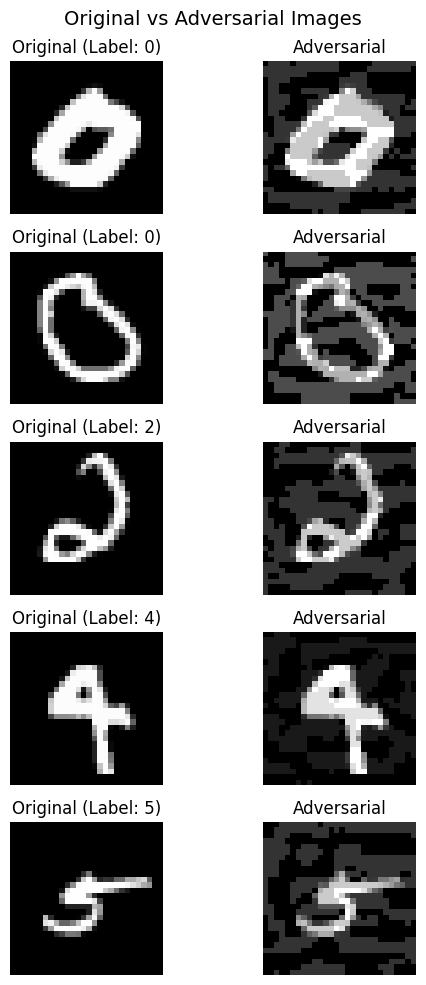

In [20]:
# Attack #1
from art.attacks.evasion.fast_gradient import FastGradientMethod

attack = FastGradientMethod(estimator=art_model_t, eps=0.4, eps_step=0.1, batch_size=32, minimal=True, targeted=False, summary_writer=True)
x_adv_fgm = attack.generate(x=mnist_data_subset, y=mnist_targets_subset)
visualize_adversarial(mnist_data_subset, x_adv_fgm, mnist_targets_subset)

DeepFool: 100%|██████████| 4/4 [00:22<00:00,  5.54s/it]


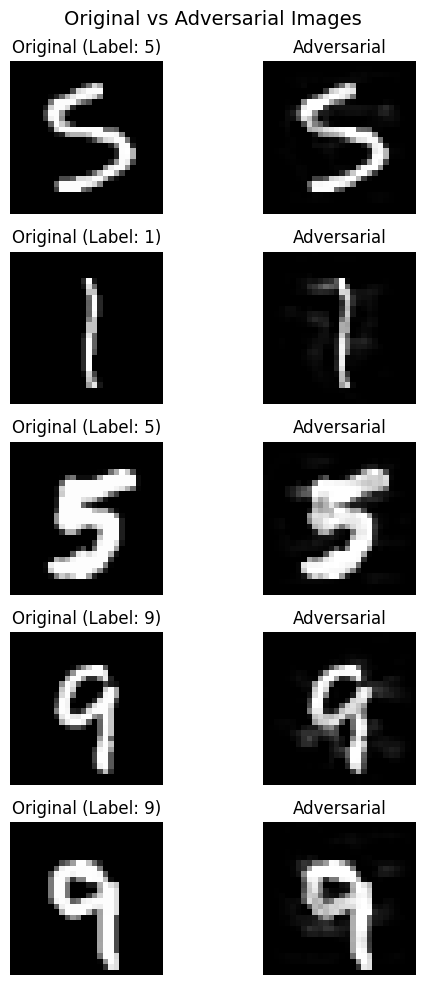

In [21]:
# Attack #2

from art.attacks.evasion.deepfool import DeepFool

attack = DeepFool(classifier=art_model_t, epsilon=0.001, max_iter=max_attack_iter, batch_size=32)
x_adv_deepfool = attack.generate(x=mnist_data_subset, y=mnist_targets_subset)
visualize_adversarial(mnist_data_subset, x_adv_deepfool, mnist_targets_subset)

In [59]:
# Attack #3

from art.attacks.evasion.carlini import CarliniL2Method

attack = CarliniL2Method(classifier=art_model_t, confidence=0.3, initial_const=0.01, max_iter=max_attack_iter, batch_size=32)
x_adv_carlini = attack.generate(x=mnist_data_subset, y=mnist_targets_subset)
visualize_adversarial(mnist_data_subset, x_adv_carlini, mnist_targets_subset)


C&W L_2:   0%|          | 0/4 [01:18<?, ?it/s]


KeyboardInterrupt: 

JSMA: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s]


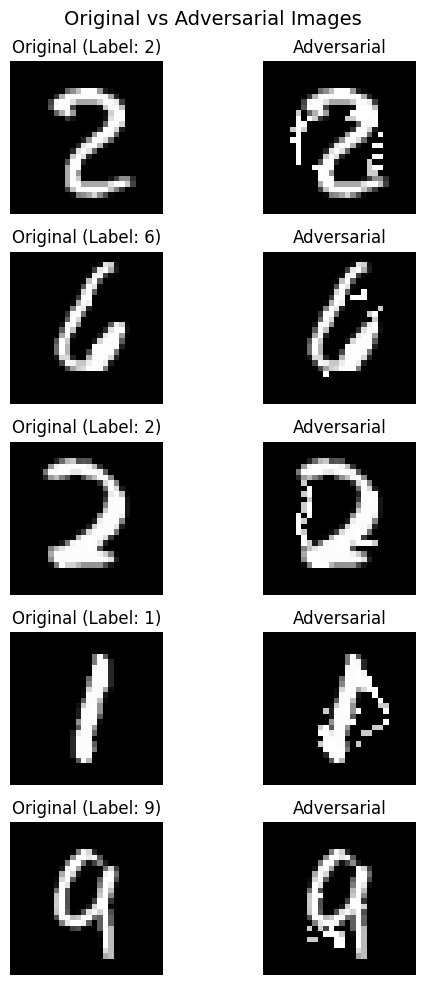

(9, 100, 1, 28, 28)


In [32]:
# Attack #4

from art.attacks.evasion.saliency_map import SaliencyMapMethod

attack = SaliencyMapMethod(classifier=art_model_t, theta=0.8, gamma=0.7, batch_size=32)
x_adv_jacobian = np.zeros((9,num_samples, n_channels, w, h))

for idx, targets in enumerate(target_y):
    x = attack.generate(x=mnist_data_subset, y=targets)
    x_adv_jacobian[idx, :, :, :] = x


visualize_adversarial(mnist_data_subset, x_adv_jacobian[0], mnist_targets_subset)
print(x_adv_jacobian.shape)

In [33]:
x_adv_jacobian = x_adv_jacobian.reshape(-1, n_channels, w, h)

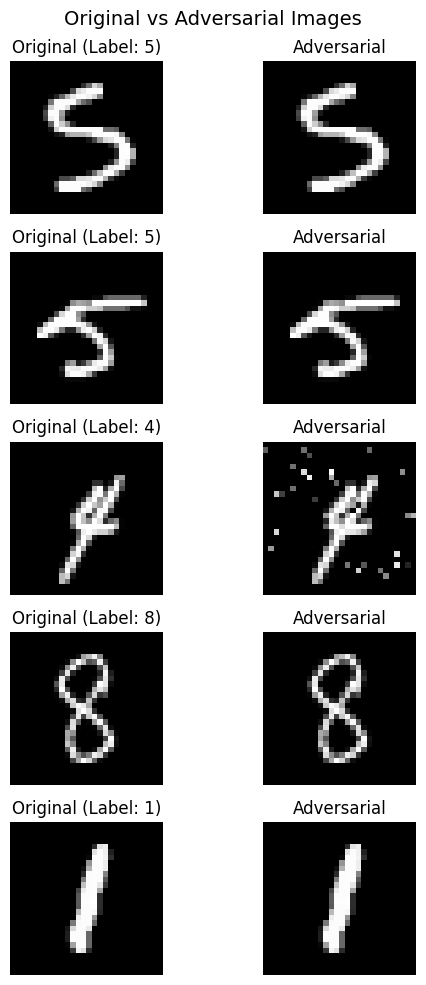

In [36]:
# Attack #5

from art.attacks.evasion.pixel_threshold import PixelAttack

attack = PixelAttack(classifier=art_model_t, th=35, es=1, max_iter=max_attack_iter)   # Increase max_iter for better results
x_adv_pixel = attack.generate(x=mnist_data_subset, y=mnist_targets_subset)
visualize_adversarial(mnist_data_subset, x_adv_pixel, mnist_targets_subset)


In [ ]:

def evaluate_model(model, data, labels, device=None):
    """
    Evaluate model accuracy.

    Args:
        model: PyTorch model (ART-wrapped or regular)
        data: Input samples (NumPy array or Tensor).
        labels: True labels as class indices (NumPy array or Tensor).
        device: "cpu" or "cuda" (use GPU if available).

    Returns:
        accuracy (float)
    """
    # Check if CUDA is available, otherwise fallback to CPU
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()  # Set model to evaluation mode

    # Convert NumPy arrays to PyTorch tensors if needed
    if isinstance(data, np.ndarray):
        data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    else:
        data_tensor = data.to(device)

    if isinstance(labels, np.ndarray):
        labels_tensor = torch.tensor(labels, dtype=torch.long).to(device)
    else:
        labels_tensor = labels.to(device)

    # Forward pass: Compute predictions
    with torch.no_grad():
        outputs = model(data_tensor)  # Get raw logits
        predictions = torch.argmax(outputs, dim=1)  # Convert logits to class labels

    # Accuracy Calculation (No one-hot encoding assumption)
    accuracy = (predictions == labels_tensor).float().mean().item() * 100

    return accuracy

In [25]:
def to_tensor(data, device):
    """Convert data to PyTorch tensor and move to device."""
    if isinstance(data, np.ndarray):
        return torch.tensor(data, dtype=torch.float32).to(device)
    return data.to(device)

def calculate_asr(preds_clean, preds_adv):
    """Calculate Adversarial Success Rate (ASR)."""
    successful_attacks = (preds_clean != preds_adv).sum().item()
    asr = (successful_attacks / len(preds_clean)) * 100
    return asr

def calculate_mean_gradient_amplitude(model, data, labels, criterion):
    """Calculate Mean Gradient Amplitude divided into 10 bins."""
    data.requires_grad = True
    outputs = model(data)
    loss = criterion(outputs, labels)
    loss.backward()
    gradients = data.grad.abs().cpu().numpy()

    # Bin gradients into 10 bins
    bins = np.linspace(0, gradients.max(), 11)
    bin_counts, _ = np.histogram(gradients, bins=bins)
    mean_gradient_amplitude = bin_counts / len(labels)
    return mean_gradient_amplitude.tolist()

def calculate_robustness(data, adv_data):
    """Calculate Robustness as the average minimum effective perturbation."""
    perturbations = (adv_data - data).view(len(data), -1).norm(p=2, dim=1)
    robustness = perturbations.mean().item()
    
    # Compute Average maximum perturbation (Normalized images)
    n_channels, w, h = data.shape[1], data.shape[2], data.shape[3]
    
    # Calculate the product of the last three dimensions
    max_robustness = n_channels * w * h

    robustness_ratio = (robustness / max_robustness) * 100

    return robustness_ratio

def calculate_adversarial_confidence(outputs_adv):
    """
    Calculate the average classification confidence on adversarial examples.
    
    Assumes that outputs_adv are log probabilities (log softmax).
    """
    # Exponentiate to get probabilities from log softmax
    probabilities = torch.exp(outputs_adv)  # Convert log softmax back to probabilities
    confidence_adv = probabilities.max(dim=1).values
    mean_confidence = confidence_adv.mean().item() * 100
    return mean_confidence


In [26]:

def evaluate_adversarial_metrics(model, data, labels, adv_data, criterion, device=None):
    """
    Evaluate model on adversarial metrics.

    Args:
        model: PyTorch model (ART-wrapped or regular).
        data: Clean input samples (NumPy array or Tensor).
        labels: True labels as class indices (NumPy array or Tensor).
        adv_data: Adversarial input samples (NumPy array or Tensor).
        device: "cpu" or "cuda" (use GPU if available).

    Returns:
        metrics (dict): Dictionary containing ASR, mean gradient amplitude, robustness, and confidence.
    """
    # Check if CUDA is available, otherwise fallback to CPU
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()  # Set model to evaluation mode

    # Convert data to PyTorch tensors if needed
    data = to_tensor(data, device)
    labels = to_tensor(labels, device).long()
    adv_data = to_tensor(adv_data, device)

    # Forward pass on clean data
    with torch.no_grad():
        outputs_clean = model(data)
        preds_clean = torch.argmax(outputs_clean, dim=1)

    # Forward pass on adversarial data
    with torch.no_grad():
        outputs_adv = model(adv_data)
        preds_adv = torch.argmax(outputs_adv, dim=1)

    # Calculate metrics
    metrics = {
        'Adversarial Success Rate': calculate_asr(preds_clean, preds_adv),
        'Mean Gradient Amplitude (10 bins)': calculate_mean_gradient_amplitude(model, data, labels, criterion),
        'Adversarial Robustness % (Avg Min Perturbation)': calculate_robustness(data, adv_data),
        'Adversarial Confidence': calculate_adversarial_confidence(outputs_adv)
    }

    return metrics


In [34]:
# FSGM
evaluate_adversarial_metrics(art_model_t.model, mnist_data_subset, mnist_targets_subset, x_adv_fgm, criterion=criterion, device='cpu')

{'Adversarial Success Rate': 98.0,
 'Mean Gradient Amplitude (10 bins)': [777.97,
  4.75,
  0.8,
  0.24,
  0.13,
  0.07,
  0.02,
  0.0,
  0.01,
  0.01],
 'Adversarial Robustness % (Avg Min Perturbation)': 0.6005849765271557,
 'Adversarial Confidence': 40.53570628166199}

In [28]:
# DeepFool
evaluate_adversarial_metrics(art_model_t.model, mnist_data_subset, mnist_targets_subset, x_adv_deepfool, criterion=criterion, device='cpu')

{'Adversarial Success Rate': 100.0,
 'Mean Gradient Amplitude (10 bins)': [777.97,
  4.75,
  0.8,
  0.24,
  0.13,
  0.07,
  0.02,
  0.0,
  0.01,
  0.01],
 'Adversarial Robustness % (Avg Min Perturbation)': 0.21062064535763797,
 'Adversarial Confidence': 41.54117703437805}

In [37]:
# One Pixel Attack
evaluate_adversarial_metrics(art_model_t.model, mnist_data_subset, mnist_targets_subset, x_adv_pixel, criterion=criterion, device='cpu')

{'Adversarial Success Rate': 22.0,
 'Mean Gradient Amplitude (10 bins)': [777.97,
  4.75,
  0.8,
  0.24,
  0.13,
  0.07,
  0.02,
  0.0,
  0.01,
  0.01],
 'Adversarial Robustness % (Avg Min Perturbation)': 0.10166293656339451,
 'Adversarial Confidence': 84.18300151824951}

In [30]:
## Teacher Model

# Original test set evaluation
original_accuracy = evaluate_model(
    art_model_t.model, mnist_data_subset, mnist_targets_subset, device=torch.device("cpu")
)
print(f"Original Test Accuracy: {original_accuracy:.2f}%")

# Adversarial test sets evaluation
fgm_accuracy = evaluate_model(
    art_model_t.model, x_adv_fgm, mnist_targets_subset
)
deepfool_accuracy = evaluate_model(
    art_model_t.model, x_adv_deepfool, mnist_targets_subset
)
#carlini_accuracy = evaluate_model(art_model_t.model, x_adv_carlini, mnist_targets_subset)

# Jacobian uses 9x the samples
#jacobian_accuracy = evaluate_model(
 #   art_model_t.model, x_adv_jacobian, mnist_targets_subset
#)
#pixel_accuracy = evaluate_model(
#    art_model_t.model, x_adv_pixel, mnist_targets_subset
#)

print(f"Test Accuracy (FGS Method): {fgm_accuracy:.2f}%")
print(f"Test Accuracy (Deepfool Method): {deepfool_accuracy:.2f}%")
#print(f"Adversarial Test Accuracy (Carlini L2 Method): {carlini_accuracy:.2f}%")
#print(f"Adversarial Test Accuracy (Jacobian Method): {jacobian_accuracy:.2f}%")
#print(f"Test Accuracy (Pixel Method): {pixel_accuracy:.2f}%")

Original Test Accuracy: 99.00%
Test Accuracy (FGS Method): 1.00%
Test Accuracy (Deepfool Method): 1.00%


In [38]:


def show_difference(original, adversarial, title="Method"):
    diff = np.abs(original - adversarial)
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(adversarial, cmap='gray')
    plt.title(f"Adversarial {title}")

    plt.subplot(1, 3, 3)
    plt.imshow(diff, cmap='hot')
    plt.title("Difference (Perturbation)")

    plt.show()


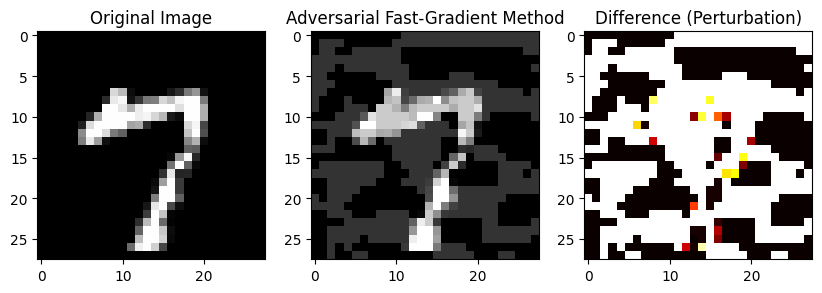

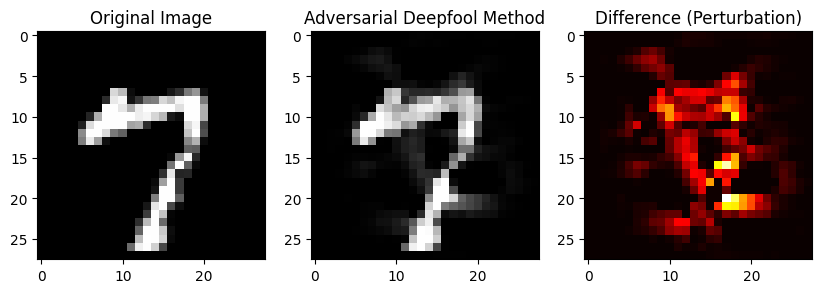

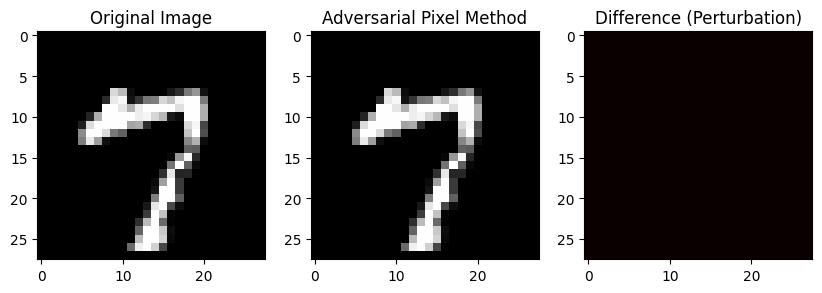

In [40]:

show_difference(mnist_data_subset[0][0], x_adv_fgm[0][0], title="Fast-Gradient Method")
show_difference(mnist_data_subset[0][0], x_adv_deepfool[0][0], title="Deepfool Method")
#show_difference(mnist_data_subset[0][0], x_adv_carlini[0][0], title="Carlini Method")
show_difference(mnist_data_subset[0][0], x_adv_pixel[0][0], title="Pixel Method")


In [45]:
np.max(mnist_data_subset)

np.float32(1.0)

In [41]:
print(f"mnist_data_subset.shape = {mnist_data_subset.shape}")
print(f"x_adv_fgm.shape = {x_adv_fgm.shape}")
print(f"x_adv_deepfool.shape = {x_adv_deepfool.shape}")
#print(f"x_adv_carlini.shape = {x_adv_carlini.shape}")
print(f"x_adv_pixel.shape = {x_adv_pixel.shape}")
print(f"x_adv_jacobian.shape = {x_adv_jacobian.shape}")


mnist_data_subset.shape = (100, 1, 28, 28)
x_adv_fgm.shape = (100, 1, 28, 28)
x_adv_deepfool.shape = (100, 1, 28, 28)
x_adv_pixel.shape = (100, 1, 28, 28)
x_adv_jacobian.shape = (900, 1, 28, 28)


In [42]:
# Generate Soft Labels

def get_soft_labels(model, dataloader, temp):
    soft_labels_list = []
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            # Get logits from trained teacher model
            logits = model(images)
            # Apply temperature-scaled softmax
            soft_labels = torch.softmax(logits / temp, dim=1)
            soft_labels_list.append(soft_labels.cpu())
    return torch.cat(soft_labels_list)

In [43]:
def distillation_loss(student_logits, teacher_soft_labels, hard_labels, temp, alpha):
    """
    Computes the distillation loss.

    Args:
        student_logits: Output logits from the student model.
        teacher_soft_labels: Soft labels generated by the teacher model.
        hard_labels: Original hard labels.
        temp: Temperature used for soft labels.
        alpha: Weight for soft loss (1-alpha for hard loss).
    """
    soft_loss = nn.KLDivLoss(reduction="batchmean")(
        torch.log_softmax(student_logits / temp, dim=1),
        teacher_soft_labels
    )
    hard_loss = nn.CrossEntropyLoss()(student_logits, hard_labels)
    return alpha * soft_loss + (1 - alpha) * hard_loss


In [44]:
def train_student(teacher_model, student_model, trainloader, temp=20, alpha=0.7, epochs=10, lr=0.01):
    """
    Trains the student model using knowledge distillation.

    Args:
        teacher_model: Pretrained teacher model.
        student_model: Student model to train.
        trainloader: DataLoader for training.
        temp: Temperature for soft labels.
        alpha: Weight for soft labels in the loss.
        epochs: Number of training epochs.
        lr: Learning rate.
    """
    student_model.train()
    optimizer = optim.Adam(student_model.parameters(), lr=lr)

    for e in tqdm(range(epochs)):
        total_loss = 0
        for images, hard_labels in trainloader:
            images, hard_labels = images.to(device), hard_labels.to(device)

            # Get teacher soft labels
            with torch.no_grad():
                teacher_logits = teacher_model(images)
                soft_labels = torch.softmax(teacher_logits / temp, dim=1)

            # Get student predictions
            student_logits = student_model(images)

            # Compute distillation loss
            loss = distillation_loss(student_logits, soft_labels, hard_labels, temp, alpha)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if e % 10 == 0:
            print(f"Epoch {e}: {loss.item()}")

    print("Training complete!")


In [45]:
# Specify Student Model

temp = temp_teacher
max_epochs = 5
alpha = 0.5
# Initialize the student model
student_model = MnistNet(input_size=28, temperature=temp_teacher).to(device)

In [46]:
teacher_model.to(device)
# Generate soft labels for training the student
soft_labels = get_soft_labels(teacher_model, trainloader, temp)

In [47]:
soft_labels[0]

tensor([0.0476, 0.0794, 0.0800, 0.0660, 0.2855, 0.0748, 0.0530, 0.0897, 0.0994,
        0.1247])

In [48]:
# Train Student
train_student(teacher_model, student_model, trainloader, temp=temp, alpha=alpha, epochs=max_epochs, lr=lr)

 20%|██        | 1/5 [00:05<00:21,  5.46s/it]

Epoch 0: 0.044453900307416916


100%|██████████| 5/5 [00:27<00:00,  5.57s/it]

Training complete!


In [49]:
# Wrap in ART PyTorchClassifier
art_model_s = PyTorchClassifier(
    model=student_model,
    clip_values=(0, 1),  # Min and Max pixel values (normalize if needed)
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10
)

In [52]:
## Student Model

# Original test set evaluation
original_accuracy = evaluate_model(
    art_model_s.model, mnist_data_subset, mnist_targets_subset
)
print(f"Original Test Accuracy: {original_accuracy:.2f}%")



Original Test Accuracy: 98.00%


In [ ]:
# Adversarial test sets evaluation

fgm_accuracy = evaluate_model(
    art_model_s.model, x_adv_fgm, mnist_targets_subset
)
deepfool_accuracy = evaluate_model(
    art_model_s.model, x_adv_deepfool, mnist_targets_subset
)
carlini_accuracy = evaluate_model(
    art_model_s.model, x_adv_carlini, mnist_targets_subset
)

print(f"Adversarial Test Accuracy (FGS Method): {fgm_accuracy:.2f}%")
print(f"Adversarial Test Accuracy (Deepfool Method): {deepfool_accuracy:.2f}%")
print(f"Adversarial Test Accuracy (Carlini L2 Method): {carlini_accuracy:.2f}%")

In [ ]:
 # FGSM
evaluate_adversarial_metrics(art_model_s.model, mnist_data_subset, mnist_targets_subset, x_adv_fgm, criterion=criterion, device='cpu')


{'Adversarial Success Rate': 7.000000000000001,
 'Mean Gradient Amplitude (10 bins)': [771.99,
  9.12,
  1.9,
  0.65,
  0.18,
  0.08,
  0.01,
  0.02,
  0.03,
  0.02],
 'Adversarial Robustness % (Avg Min Perturbation)': 0.10166293656339451,
 'Adversarial Confidence': 82.36961364746094}

In [54]:
# Deepfool
evaluate_adversarial_metrics(art_model_s.model, mnist_data_subset, mnist_targets_subset, x_adv_deepfool, criterion=criterion, device='cpu')


{'Adversarial Success Rate': 20.0,
 'Mean Gradient Amplitude (10 bins)': [771.99,
  9.12,
  1.9,
  0.65,
  0.18,
  0.08,
  0.01,
  0.02,
  0.03,
  0.02],
 'Adversarial Robustness % (Avg Min Perturbation)': 0.21062064535763797,
 'Adversarial Confidence': 57.29935169219971}

In [55]:
# One Pixel Attack
evaluate_adversarial_metrics(art_model_s.model, mnist_data_subset, mnist_targets_subset, x_adv_pixel, criterion=criterion, device='cpu')

{'Adversarial Success Rate': 7.000000000000001,
 'Mean Gradient Amplitude (10 bins)': [771.99,
  9.12,
  1.9,
  0.65,
  0.18,
  0.08,
  0.01,
  0.02,
  0.03,
  0.02],
 'Adversarial Robustness % (Avg Min Perturbation)': 0.10166293656339451,
 'Adversarial Confidence': 82.36961364746094}